https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
import re
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
dataset = pd.read_csv('data/weatherAUS.csv')

Okay, so we have all of these locations a-and we also have wind speed and direction. We can use nearby locations at the same day or during previous week. The rain could possibly travel from nearby locations.
Also, and this should be our first choice, we should consider data from previous week at the same location we are trying to predict weather for.

But first of all, we need to look at the data. Split the data and then look at it.

I will split the data in a way that preserves all of the locations. The test set will consist of the most recent dates in the dataset.

In [3]:
dataset.sort_values(['Date', 'Location'], inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [4]:
dataset.iloc[109102:].head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
109102,2015-06-14,Woomera,13.3,16.2,0.0,NaN,NaN,E,33.0,E,...,97.0,88.0,1021.8,1019.0,7.0,7.0,13.6,15.5,No,No
109103,2015-06-15,Adelaide,13.2,15.5,1.2,2.8,NaN,E,24.0,SSE,...,84.0,75.0,1021.5,1018.6,NaN,NaN,13.9,15.4,Yes,Yes
109104,2015-06-15,Albany,13.6,18.8,0.8,1.2,5.9,NaN,NaN,SE,...,78.0,66.0,1023.1,1021.4,6.0,2.0,16.2,17.7,No,Yes
109105,2015-06-15,Albury,1.8,14.0,0.2,NaN,NaN,ESE,17.0,NaN,...,100.0,70.0,1027.4,1023.5,4.0,8.0,5.9,13.9,No,Yes
109106,2015-06-15,AliceSprings,10.2,25.6,0.0,2.4,7.5,WNW,31.0,NE,...,90.0,35.0,1019.8,1016.0,8.0,6.0,15.7,24.2,No,No


In [5]:
(dataset.shape[0] - 109103)/dataset.shape[0]

0.24994500206242265

As indeces are sorted by date and location, it is clear that at the 109103's index the locations are rounding up and starting from the beginning, which means, I can split there to have a test set which size is almost 25% of the whole dataset.

In [6]:
train, test = dataset.iloc[:109103], dataset.iloc[109103:]

Probability of rain in testset: 0.28180
</br>Probability of rain in trainset: 0.2864

In [7]:
def rolling_features_for_all_locations(series_, locations, period, shift, strategy):
    all_locations = []
    for location in locations.unique():
        one_location, index = series_[locations == location].reset_index(drop=True, inplace=False), series_[locations == location].index.to_series()
        new_series_for_location = rolling_features_for_location(one_location, period, shift, strategy)
        new_series_for_location.index = index
        all_locations += [new_series_for_location]
    return pd.concat(all_locations, axis=0)

In [8]:
def rolling_features_for_location(series_, period, shift, strategy):
    first_n = []
    for i in range(period):
        if i == 0:
            first_n += [series_[i]]
        else:
            if strategy == 'mean':
                first_n += [series_[:i+1-shift].mean()]
            elif strategy == 'median':
                first_n += [series_[:i+1-shift].median()]
            elif strategy == 'sum':
                first_n += [series_[:i+1-shift].sum()]
            else:
                raise ValueError('Wrong strategy.')
                
    if strategy == 'mean':
        new_series = series_.shift(shift).rolling(period).mean()
    elif strategy == 'median':
        new_series = series_.shift(shift).rolling(period).median()
    elif strategy == 'sum':
        new_series = series_.shift(shift).rolling(period).sum()
    else:
        raise ValueError('Wrong strategy.')
        
    new_series[:period] = first_n
    return new_series

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109103 entries, 0 to 109102
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           109103 non-null  object 
 1   Location       109103 non-null  object 
 2   MinTemp        108183 non-null  float64
 3   MaxTemp        108387 non-null  float64
 4   Rainfall       106747 non-null  float64
 5   Evaporation    66696 non-null   float64
 6   Sunshine       62850 non-null   float64
 7   WindGustDir    100954 non-null  object 
 8   WindGustSpeed  100999 non-null  float64
 9   WindDir9am     100750 non-null  object 
 10  WindDir3pm     106571 non-null  object 
 11  WindSpeed9am   107562 non-null  float64
 12  WindSpeed3pm   107563 non-null  float64
 13  Humidity9am    107238 non-null  float64
 14  Humidity3pm    107314 non-null  float64
 15  Pressure9am    98248 non-null   float64
 16  Pressure3pm    98283 non-null   float64
 17  Cloud9am       68821 non-null

In [10]:
class Preprocessor:
    def __init__(self):
        self.locations = None
        
    def preprocess(self, _data):
        data = _data.copy(deep=True)
        for column in ['RainToday', 'RainTomorrow']:
            data.loc[data[column] == 'Yes', column] = 1
            data.loc[data[column] == 'No', column] = 0

        data['Year'] = pd.DatetimeIndex(data['Date']).year
        data['Month'] = pd.DatetimeIndex(data['Date']).month

        data['Location'] = data['Location'].apply(lambda loc: ' '.join(re.findall('[A-Z][^A-Z]+|[A-Z]+', loc)))
        data.loc[data.Location == 'Portland', 'Location'] = 'Portland, Victoria'
        data.loc[data.Location == 'Dartmoor', 'Location'] = 'Dartmoor, Victoria'
        data.loc[data.Location == 'Perth', 'Location'] = 'Perth, Western Australia'
        data.loc[data.Location == 'Richmond', 'Location'] = 'Richmond, New South Wales'
        data['Location'] = data.Location + ', Australia'
        
        if self.locations is None:
            geolocator = Nominatim(user_agent="rain-in-australia-app")
            locations = {'Location': [], 'Address': [], 'Latitude': [], 'Longitude': []}
            for location in data.Location.unique().tolist()+['Australia']:
                location_enc = geolocator.geocode(location, language='en')
                if location_enc is None:
                    raise ValueError(f'Location not found: {location}')
                locations['Location'] += [location]
                locations['Address'] += [location_enc.address]
                locations['Latitude'] += [location_enc.latitude]
                locations['Longitude'] += [location_enc.longitude]    
            self.locations = pd.DataFrame(locations)
        data = data.merge(self.locations[['Location','Latitude','Longitude']], left_on='Location', right_on='Location')
        return data

In [11]:
preprocessor = Preprocessor()
train_prep = preprocessor.preprocess(train)

In [12]:
test_prep = preprocessor.preprocess(test)

RainToday vs RainTomorrow:

In [13]:
train_prep.loc[train_prep.RainToday == 1, 'RainTomorrow'].value_counts()

0    12584
1    11082
Name: RainTomorrow, dtype: int64

In [14]:
def compare(data, filter_, filter_verbose, column, strategy='median'):
    if strategy == 'median':
        true = train_prep.loc[filter_, column].median()
        false = train_prep.loc[~filter_, column].median()
    elif strategy == 'mean':
        true = train_prep.loc[filter_, column].mean()
        false = train_prep.loc[~filter_, column].mean()
    else:
        raise ValueError('Wrong strategy.')
    print(f'{column} when {filter_verbose}:')
    print(f'{strategy} if true: {true}, {strategy} if false: {false}\ndifference: {true-false}')

Comparing against target value in general:

In [15]:
cols = ['WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'Rainfall']
for col in cols:
    compare(train_prep, train_prep.RainTomorrow == 1, 'RainTomorrow', col)
    print()

WindGustSpeed when RainTomorrow:
median if true: 44.0, median if false: 37.0
difference: 7.0

WindSpeed9am when RainTomorrow:
median if true: 15.0, median if false: 13.0
difference: 2.0

WindSpeed3pm when RainTomorrow:
median if true: 19.0, median if false: 17.0
difference: 2.0

Humidity9am when RainTomorrow:
median if true: 80.0, median if false: 67.0
difference: 13.0

Humidity3pm when RainTomorrow:
median if true: 70.0, median if false: 48.0
difference: 22.0

Pressure9am when RainTomorrow:
median if true: 1014.2, median if false: 1018.3
difference: -4.099999999999909

Pressure3pm when RainTomorrow:
median if true: 1012.1, median if false: 1015.9
difference: -3.7999999999999545

Cloud9am when RainTomorrow:
median if true: 7.0, median if false: 4.0
difference: 3.0

Cloud3pm when RainTomorrow:
median if true: 7.0, median if false: 4.0
difference: 3.0

Temp9am when RainTomorrow:
median if true: 16.1, median if false: 16.8
difference: -0.6999999999999993

Temp3pm when RainTomorrow:
median

Temperature and pressure are lower, wind speed, himidity and clouds are higher.

How many rainy days were there prior to the target date?

In [16]:
roll = rolling_features_for_all_locations(train_prep.RainToday, train.Location, period=3, shift=0, strategy='sum')

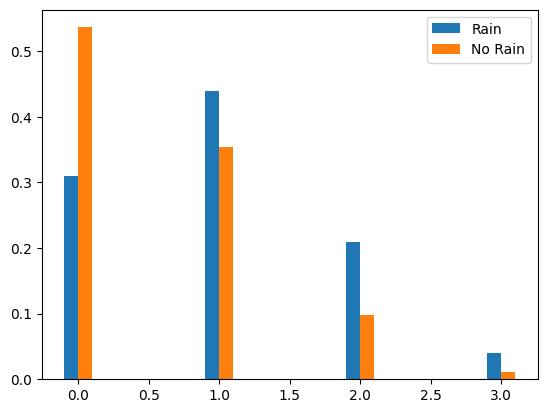

In [17]:
ax = plt.subplot(111)
bar_ = roll.loc[train_prep.RainTomorrow == 1].value_counts(normalize=True).sort_index()
ax.bar(bar_.index-0.05, bar_.values, width=0.1, label='Rain')
bar_ = roll.loc[train_prep.RainTomorrow == 0].value_counts(normalize=True).sort_index()
ax.bar(bar_.index+0.05, bar_.values, width=0.1, label='No Rain')
plt.legend()

Average pressure prior to the target date:

In [18]:
train_prep.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Year', 'Month', 'Latitude',
       'Longitude'],
      dtype='object')

In [19]:
def rolls(column, period, shift):
    roll = rolling_features_for_all_locations(train_prep[column], train.Location, period=period, shift=shift, strategy='median').rename(f'{column}_{3}_days')
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.01, random_state=42)
    for train_i, test_i in split.split(train_prep, train_prep.Location):
        sample, y = roll.loc[test_i], train.RainTomorrow.fillna('No').loc[test_i]
    sns.violinplot(x=sample, y = y)    

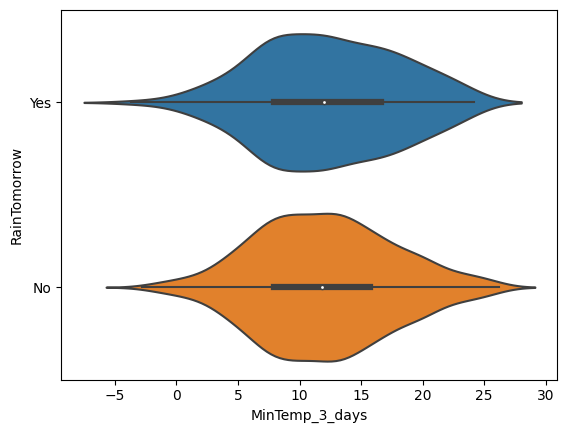

In [20]:
rolls('MinTemp', 3, 0)

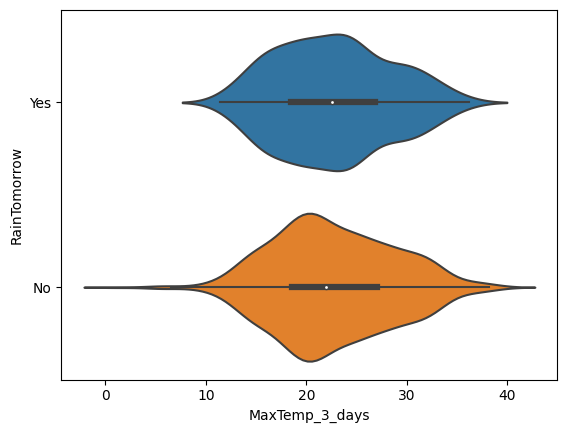

In [21]:
rolls('MaxTemp', 3, 0)

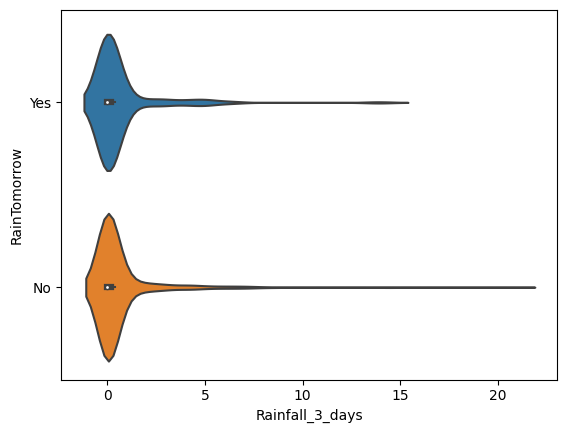

In [22]:
rolls('Rainfall', 3, 0)

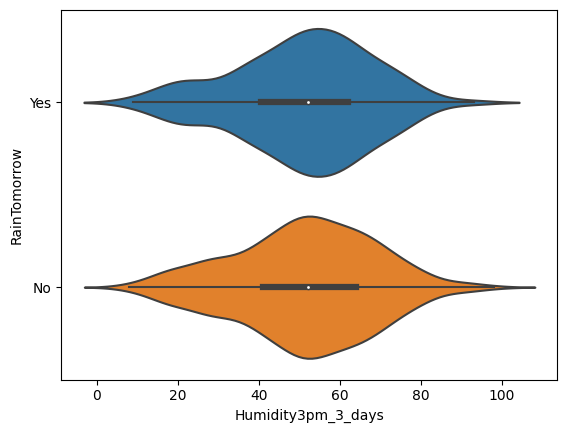

In [23]:
rolls('Humidity3pm', 3, 0)

Amount of rainy days vs month:

In [27]:
series_ = train_prep.loc[train_prep.RainTomorrow == 1, 'Month'].value_counts().sort_index()

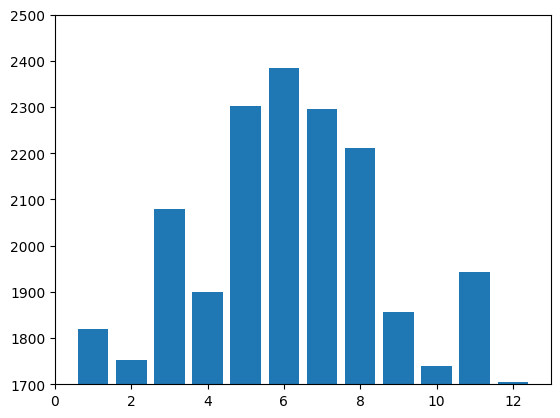

In [28]:
plt.bar(series_.index, series_.values)
ax = plt.axis([0, 13, 1700, 2500])

Probability of rain vs location:

Location names listed below can be found in multiple states of Australia, so I looked up on http://www.bom.gov.au/climate/dwo which towns they meant exactly.
</br>Portland (__Victoria__, New South Wales)
</br>Dartmoor (__Victoria__, Western Australia)
</br>Perth (Tasmania, __Western Australia__)
</br>Richmond (South Australia, __New South Wales__, Victoria)

In [78]:
map_ = folium.Map(preprocessor.locations.iloc[-1, [-2,-1]], width=500,height=500, tiles='OpenStreetMap', zoom_start=4)

rains_vs_locations = train_prep.loc[train_prep.RainTomorrow ==1, 'Location'].value_counts(normalize=True)
for Location, latitude, longitude in preprocessor.locations[['Location', 'Latitude', 'Longitude']].values[:-1]:
    folium.CircleMarker(location=[latitude, longitude],
                        radius=rains_vs_locations.loc[Location]*400,
                        weight=5).add_to(map_)
map_

Most rains fall on seashores.

Get distance to seashore: https://stackoverflow.com/questions/65300026/distance-from-ships-to-coastline-in-nautical-miles

In [99]:
def wind_direction_vs_city(data, city, rain = True):
    if rain:
        wind = train_prep.loc[train_prep.Location.str.contains(city) & train_prep.RainTomorrow == 1, ['WindGustDir']]
    else:
        wind = train_prep.loc[train_prep.Location.str.contains(city) & train_prep.RainTomorrow == 0, ['WindGustDir']]
    wind.value_counts().plot.bar()
    r = plt.xticks(rotation = 30)
    plt.show()
    city_map = folium.Map(preprocessor.locations.loc[preprocessor.locations.Location.str.contains(city), ['Latitude', 'Longitude']], width=500,height=500, tiles='OpenStreetMap', zoom_start=10)
    return city_map

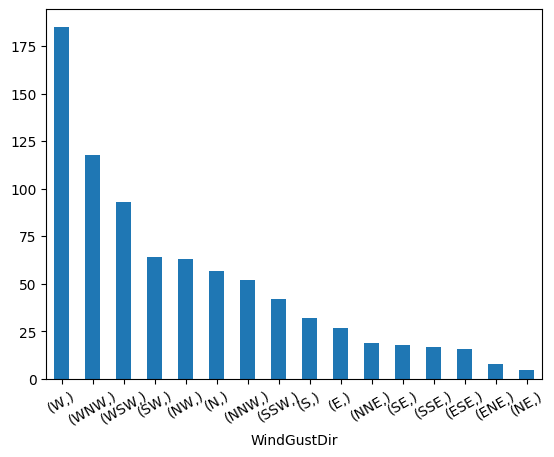

In [74]:
city = wind_direction_vs_city(train_prep, 'Portland')

In [75]:
city

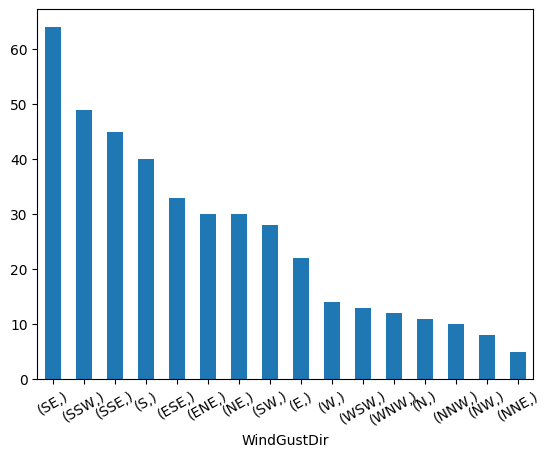

In [76]:
city = wind_direction_vs_city(train_prep, 'Richmond')

In [77]:
city

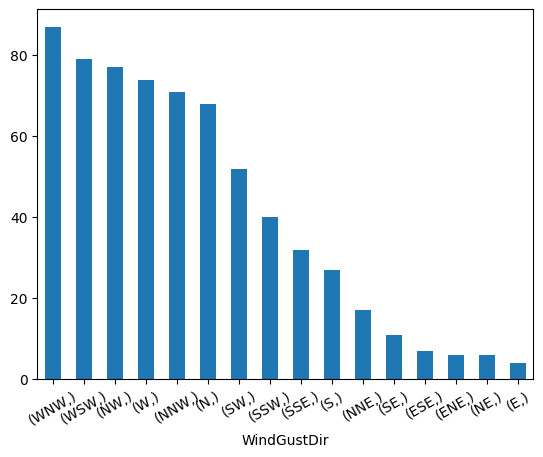

In [79]:
city = wind_direction_vs_city(train_prep, 'Witchcliffe')

In [80]:
city

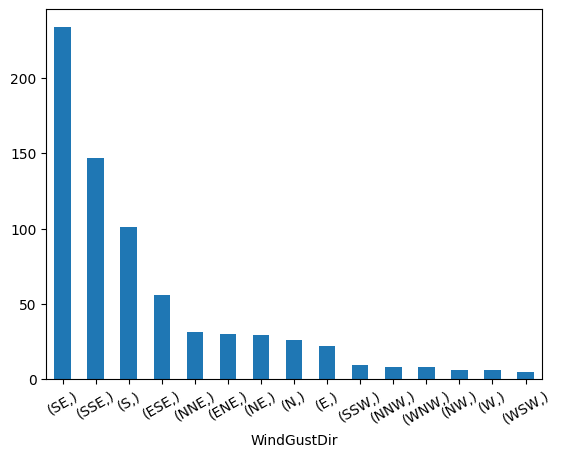

In [94]:
city = wind_direction_vs_city(train_prep, 'Cairns')

In [95]:
city

Most importantly, winds come from all over the place 

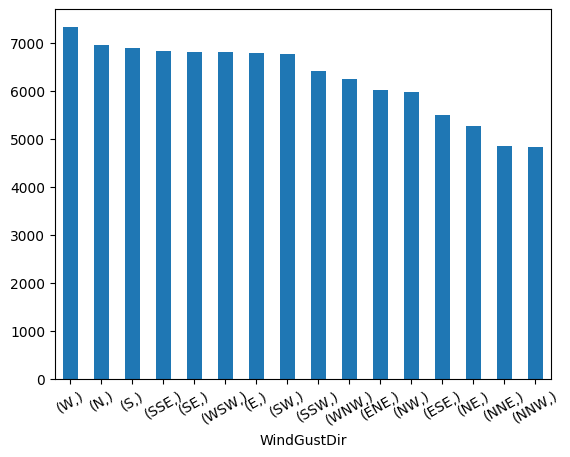

In [101]:
city = wind_direction_vs_city(train_prep, 'Cairns', rain=False)

Rain comes when speed gusts come from plains or coastlines